<h1><b><center> Classification Machine Learning in Credit Card Fraud Detection</center></b></h1>

- Decision Tree and Support Vector Machine are the machine learning models that will be used.
- The dataset includes European credit card transaction information from 2013.

In [1]:
#Install the opendatasets package
#opendatasets is a Python library for downloading datasets from online sources like Kaggle and Google Drive
#!pip install opendatasets

import opendatasets as od

#Download the dataset (this is a Kaggle dataset)
#Kaggle>Settings>API>Create new token; Input your Kaggle username and key
od.download("https://www.kaggle.com/mlg-ulb/creditcardfraud")

Skipping, found downloaded files in ".\creditcardfraud" (use force=True to force download)


In [2]:
#Import libraries
#!pip install snapml

from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score

import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Create a Dataframe
raw_data = pd.read_csv('creditcardfraud/creditcard.csv')
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

#Display the first 5 rows in the dataset
raw_data.head()

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**A financial institution may have a much bigger dataset than we currently have, so we will inflate the original one 10 times.**

In [4]:
n_replicas = 10

#Inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


The **class** variable is the target variable (1=fraud, 0=no fraud). This is an example of binary classification. 

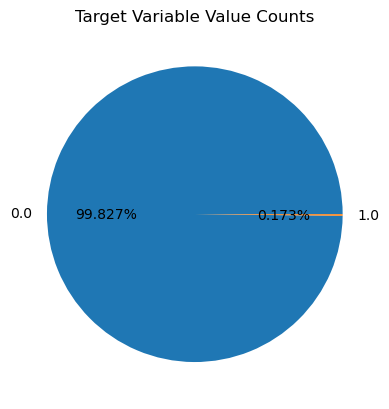

In [5]:
#Retrieve basic statistics
#Get the set of distinct Classes
labels = big_raw_data.Class.unique()

#Get the count of each Class
sizes = big_raw_data.Class.value_counts().values

#Plot the Class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

We can visualize the Class variable and see that it is a binary classification model (1=fraudulent, 0=legitimate) with a highly unbalanced dataset (99.827% vs. 0.173%)

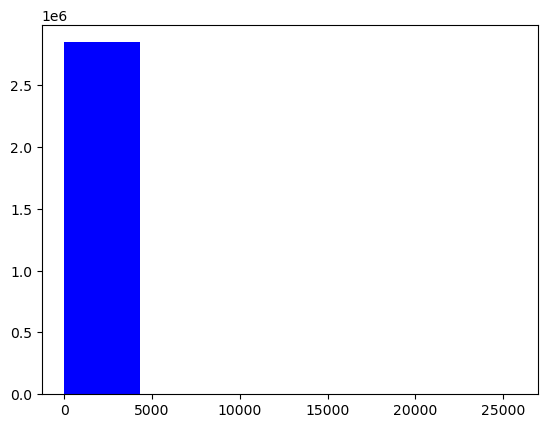

Minimum amount value is  0.0
Maximum amount value is  25691.16
90% of the transactions have an amount less or equal than  203.0


In [6]:
#Plot a histogram that shows the distribution of the credit card amounts
plt.hist(big_raw_data.Amount.values, 6, histtype='bar', facecolor='b')
plt.show()

print("Minimum amount value is ", np.min(big_raw_data.Amount.values))
print("Maximum amount value is ", np.max(big_raw_data.Amount.values))
print("90% of the transactions have an amount less or equal than ", np.percentile(raw_data.Amount.values, 90))

## **Dataset Preprocessing**

In [7]:
#Data preprocessing such as scaling/normalization is typically useful for linear models to accelerate the training convergence

#Standardize features by removing the mean and scaling to unit variance
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

#X: feature matrix (for this analysis, exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

#Data normalization:
#Scale the values so the range of the row/column values is between 0-1
#The L1-norm is the sum of the absolute values of the vector elements
X = normalize(X, norm="l1")

#Print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


## **Dataset Train/Split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #30% of data is testing set     
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


This means there are 1993649 samples in training set and 854421 in the testing set. 

### **Using Scikit-Learn to Build a Decision Tree Classifier model**

In [9]:
#Compute the sample weights to be used as input to the train (account for class imbalance in dataset)
#'balanced': n_samples / (n_classes * np.bincount(y))
wgt_train = compute_sample_weight('balanced', y_train)

#Import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

#Train a Decision Tree Classifier using scikit-learn
#get the time in seconds since epoch by using Time module.
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=wgt_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  79.34737


### **Using Snap ML to Build a Decision Tree Classifier model**

In [10]:
#Import the Decision Tree Classifier Model from Snap ML
#Snap ML offers multi-threaded CPU/GPU training of decision trees
from snapml import DecisionTreeClassifier

#The n_jobs parameter sets the number of CPU threads used at training time
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)

#Train a Decision Tree Classifier model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=wgt_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  4.45686


We can see that Snap ML was much faster than the sci-kitlearn Decision Tree Classifier Model!

## **Evaluation of Decision Tree Classification Models**

In [11]:
#Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

#Compute the probabilities of the test samples belonging to the class of fraudulent transactions
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

#Evaluate the Compute Area Under the Receiver Operating Characteristic Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

#Compute the probabilities of the test samples belonging to the class of fraudulent transactions
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]

#Evaluate the (ROC-AUC) score from the prediction scores
snapml_roc_auc = roc_auc_score(y_test, snapml_pred)   
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 17.80x 
[Scikit-Learn] ROC-AUC score : 0.966
[Snap ML] ROC-AUC score : 0.966


Even though Snap ML is ~18 times faster than Sci-kitlearn, they produce the same result.

## **Using Scikit-Learn to Build a Support Vector Machine Model**

An **SVM** is an algorithm commonly used by supervised machine learning models that offer a higher degree of accuracy compared to other classification models (e.g. KNN algorithm). 
- Separates data into different classes of data by using an optimal *hyperplane*(a decision boundary that separates classes of data) supported by **support vectors**.

Source: https://datagy.io/python-support-vector-machines/

In [13]:
#Import the linear Support Vector Machine (SVM) model from Scikit-Learn
from sklearn.svm import LinearSVC

#Create a scikit-learn SVM model
#Set class_weight='balanced' to indicate the class imbalance at fit time
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)

#Train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  92.19


In [14]:
#Import the Support Vector Machine model (SVM) from Snap ML
from snapml import SupportVectorMachine

#n_jobs parameter:number of threads used at training time
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)


#Train an SVM model using Snap ML
t0 = time.time()
model = snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.2f}".format(snapml_time))

[Snap ML] Training time (s):  16.88


## **Evaluation of SVM Models**

In [15]:
#Compute the Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))

#Run inference using the Scikit-Learn model
#Get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)

#Evaluate accuracy on test set
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))

#Run inference using the Snap ML model
#Get the confidence scores for the test samples
snapml_pred = snapml_svm.decision_function(X_test)

#Evaluate accuracy on test set
acc_snapml  = roc_auc_score(y_test, snapml_pred)
print("[Snap ML] ROC-AUC score:   {0:.3f}".format(acc_snapml))

[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : 5.46x 
[Scikit-Learn] ROC-AUC score:   0.984
[Snap ML] ROC-AUC score:   0.985


<h1><b><center> SVM Model Quality</center></b></h1>

## **Hinge-Loss Metrics**

In [16]:
from sklearn.metrics import hinge_loss

#Get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred  = snapml_svm.decision_function(X_test)

#Evaluate the hinge loss from the predictions
loss_snapml = hinge_loss(y_test, snapml_pred)
print("[Snap ML] Hinge loss:   {0:.3f}".format(loss_snapml))

#Evaluate the hinge loss metric from the predictions
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss:   {0:.3f}".format(loss_snapml))


[Snap ML] Hinge loss:   0.228
[Scikit-Learn] Hinge loss:   0.228


## **Resources**
https://pypi.org/project/opendatasets/

https://pypi.org/project/snapml/

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

https://www.geeksforgeeks.org/python-time-time-method/

https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html

https://datagy.io/python-support-vector-machines/

https://towardsdatascience.com/a-definitive-explanation-to-hinge-loss-for-support-vector-machines-ab6d8d3178f1

These notes were made for the IBM Data Science Certificate from Coursera. The lab notebook for this module was created by Andreea Anghel and Joseph Santarcangelo.